In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
import time
import warnings # prevent warnings
import joblib
from sklearn import metrics
import sys

In [15]:
site = 'C'

In [16]:
# load the data
# get parent directory
os.chdir("../..")
data_directory = 'Data_clean'
data_name = site + '_data_clean.csv'

data = pd.read_csv(os.path.join(os.getcwd(), data_directory, data_name), index_col = 0)

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [17]:
# load train data to calculate variance using train data
data_train = pd.read_csv("data_train.csv", index_col = 0)

In [18]:
# drop irrelevant columns
data = data.drop(columns = ['Wind_speed_sd'])

In [19]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'TI',
       'Temperature', 'Power'])

In [20]:
# load trained models 
forest_all = joblib.load("forest_all.pkl")

In [21]:
data_train

,ts,Month,Day,Hour,instanceID,Wind_speed,TI,Temperature,Power
395052,2020-05-10 15:20:00,5,10,15,C_WTG01,7.900000,24.246294,7.738333,1161.069946
489027,2020-06-10 17:10:00,6,10,17,C_WTG01,6.137338,11.976684,11.253334,431.023064
815535,2020-09-26 16:30:00,9,26,16,C_WTG01,2.981927,16.486589,15.045000,22.673340
600978,2020-07-17 17:40:00,7,17,17,C_WTG01,3.696848,21.221244,14.026667,73.544284
751359,2020-09-05 11:10:00,9,5,11,C_WTG01,7.433360,13.744645,12.183333,950.906729
...,...,...,...,...,...,...,...,...,...
48845,2020-01-17 03:30:00,1,17,3,C_WTG21,5.888219,13.888784,5.418333,562.047208
593165,2020-07-15 03:30:00,7,15,3,C_WTG21,4.657002,16.132754,11.220000,210.426899
546713,2020-06-29 18:50:00,6,29,18,C_WTG21,10.369692,8.756958,10.800000,1990.417444
861167,2020-10-11 18:30:00,10,11,18,C_WTG21,3.429893,12.941757,9.196666,65.283786


In [22]:
data

,ts,Month,Day,Hour,Week,instanceID,Wind_speed,TI,Temperature,Power
1,2020-01-01,1,1,0,1,C_WTG02,4.062859,11.707602,4.273333,144.951967
3,2020-01-01,1,1,0,1,C_WTG04,4.695373,15.176091,5.270000,160.230282
4,2020-01-01,1,1,0,1,C_WTG05,3.614577,15.750575,5.451667,64.632802
5,2020-01-01,1,1,0,1,C_WTG06,3.526409,19.338555,5.393333,65.132216
6,2020-01-01,1,1,0,1,C_WTG07,4.067837,15.708470,5.593333,100.370317
...,...,...,...,...,...,...,...,...,...,...
1106799,2021-01-01,1,1,0,53,C_WTG16,7.277958,8.877151,3.032759,800.435183
1106800,2021-01-01,1,1,0,53,C_WTG17,3.293306,24.411169,3.100000,99.137754
1106802,2021-01-01,1,1,0,53,C_WTG19,6.826774,11.834653,2.510345,680.744135
1106803,2021-01-01,1,1,0,53,C_WTG20,6.148926,12.236465,3.451724,542.628140


In [23]:
%%time
############################################## predict using train ################################################### 

turbines = data.instanceID.unique()
results = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data_train[data_train['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 5:-1].values
    
    # load model based on turbine number
    forest_temp = forest_all[ID]

    # predict
    pred = forest_temp.predict(X)

    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], 
                          axis = 1)
    
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 1.95 s


In [24]:
results.head()

,ts,Month,Day,Hour,instanceID,Wind_speed,TI,Temperature,Power,Predicted_power
410299,2020-05-15 16:20:00,5,15,16,C_WTG02,7.184900,9.962361,7.136207,1096.866811,1002.144271
890758,2020-10-21 13:30:00,10,21,13,C_WTG02,3.264120,15.296064,10.820000,31.812128,48.983031
320020,2020-04-15 19:50:00,4,15,19,C_WTG02,3.461468,19.180626,6.300000,104.291399,88.702663
332053,2020-04-19 19:20:00,4,19,19,C_WTG02,9.210330,6.769892,10.166667,1900.354159,1843.407112
648292,2020-08-02 09:10:00,8,2,9,C_WTG02,3.642551,21.334941,13.145000,74.006387,84.309254


In [25]:
# create dataframe for the results
results = results.assign(Error = results['Predicted_power'] - results['Power'])

In [26]:
# define sigma 
sigma_3 = 3*results['Error'].std()
sigma_2 = 2*results['Error'].std()
sigma_1 = 1*results['Error'].std()

In [27]:
%%time
########################################### predict entire dataset ################################################### 

turbines = data.instanceID.unique()
results_all = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 6:-1].values
    
    # load model based on turbine number
    forest_temp = forest_all[ID]

    # predict
    pred = forest_temp.predict(X)

    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], 
                          axis = 1)
    
    if results_all.empty: 
        results_all = data_temp
    else:
        results_all = pd.concat([results_all, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 7.27 s


In [28]:
# create dataframe for the results_all
results_all = results_all.assign(Error = results_all['Predicted_power'] - results_all['Power'])

In [29]:
results_all = results_all.assign(UWL = results_all['Predicted_power'] + sigma_2)
results_all = results_all.assign(LWL = results_all['Predicted_power'] - sigma_2)

In [30]:
# create dataframe for the results
results_all = results_all.assign(CI_width = results_all['UWL'] - results_all['LWL'])

# classify outlier 
results_all['Outlier_pred'] = (results_all['Power'] < results_all['LWL']) | (results_all['Power'] > results_all['UWL'])
results_all['Under_pred'] = (results_all['Power'] < results_all['LWL'])
results_all['Over_pred'] = (results_all['Power'] > results_all['UWL'])
results_all['Sample_count'] = 1

In [31]:
# create dataframe for normal and outlier data     
outlier_all = results_all[(results_all['Under_pred'] == 1) | (results_all['Over_pred'] == 1)]
outlier_under = results_all[results_all['Under_pred'] == 1]
outlier_over = results_all[results_all['Over_pred'] == 1]

In [19]:
MSE = metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power']))
MAE = metrics.mean_absolute_error(results_all['Power'], results_all['Predicted_power'])
MedAE = metrics.median_absolute_error(results_all['Power'], results_all['Predicted_power'])

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

MSE: 2939.6751268813837
RMSE: 54.21877098276374
MAE: 37.60531688377297
MedAE: 24.676575893645186


In [20]:
results_T01 = results_all[results_all['instanceID'] == site + "_WTG01"]
MSE = metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power']))
MAE = metrics.mean_absolute_error(results_T01['Power'], results_T01['Predicted_power'])
MedAE = metrics.median_absolute_error(results_T01['Power'], results_T01['Predicted_power'])

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

MSE: 2681.1271720059976
RMSE: 51.77960189115012
MAE: 35.47682947409754
MedAE: 22.981999659891443


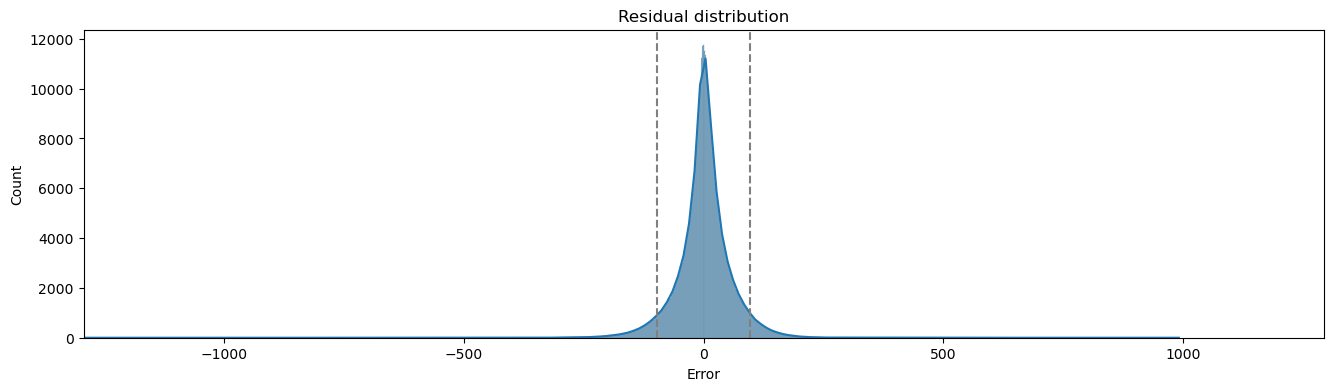

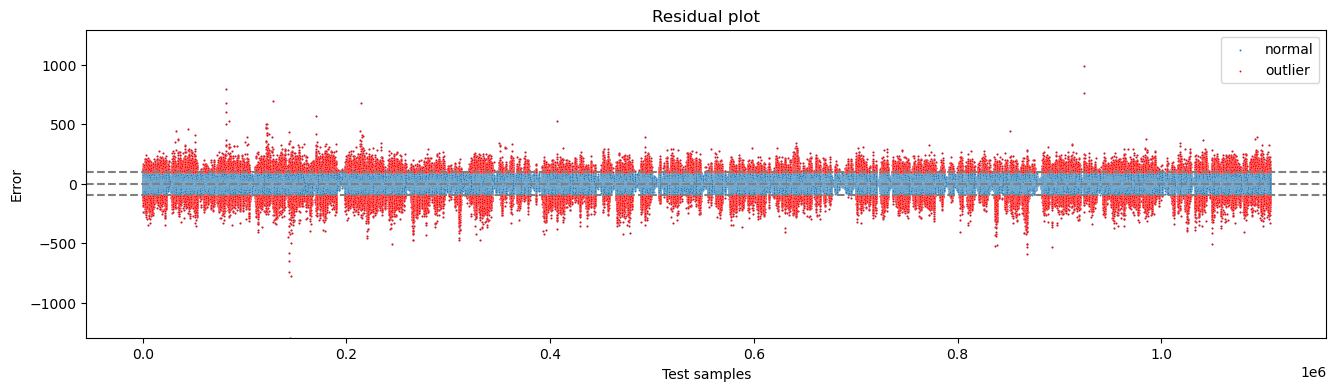

In [33]:
plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'Error', kde = True)
plt.axvline(x = -sigma_2, color = 'gray', linestyle = '--')
plt.axvline(x = sigma_2, color = 'gray', linestyle = '--')
plt.xlim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.title('Residual distribution')
plt.show()

temp = results_all[results_all['Outlier_pred'] == 1]
plt.subplots(figsize = (16,4))
sns.scatterplot(data = results_all, x = results_all.index.values, y = results_all['Error'], s=2, label = 'normal')
sns.scatterplot(data = temp, x = temp.index.values, y = temp['Error'], color = 'red', s=2, label = 'outlier')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = 0, color = 'gray', linestyle = '--')
plt.ylim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.xlabel('Test samples')
plt.title('Residual plot')
plt.legend()
plt.show()


In [34]:
temp_data = results_all[results_all['instanceID'] == site + '_WTG05']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

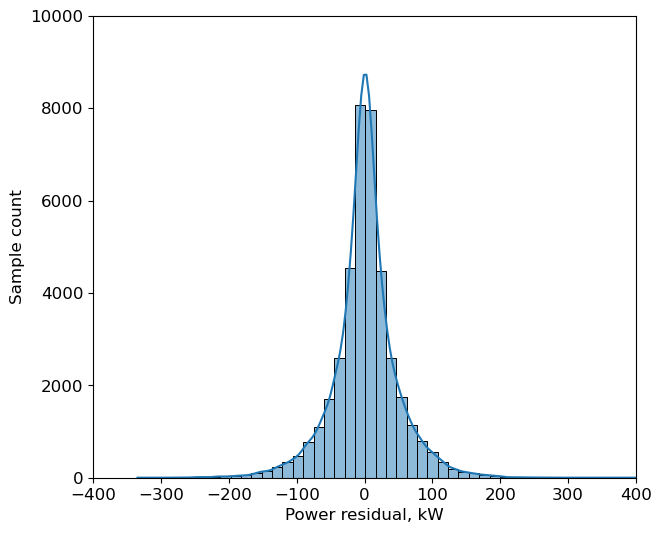

In [39]:
plt.rc('font', size=12)
plt.subplots(figsize = (7, 6))
sns.histplot(data = temp_data, x = 'Error', kde = True, bins = 50)
plt.xlim(-max(abs(temp_data.Error.max()), abs(temp_data.Error.min())), 
         max(abs(temp_data.Error.max()), abs(temp_data.Error.min())))
# plt.title('Residual distribution')
plt.ylim([0, 10000])
plt.xlim([-400, 400])
plt.xlabel('Power residual, kW')
plt.ylabel('Sample count')
plt.show()


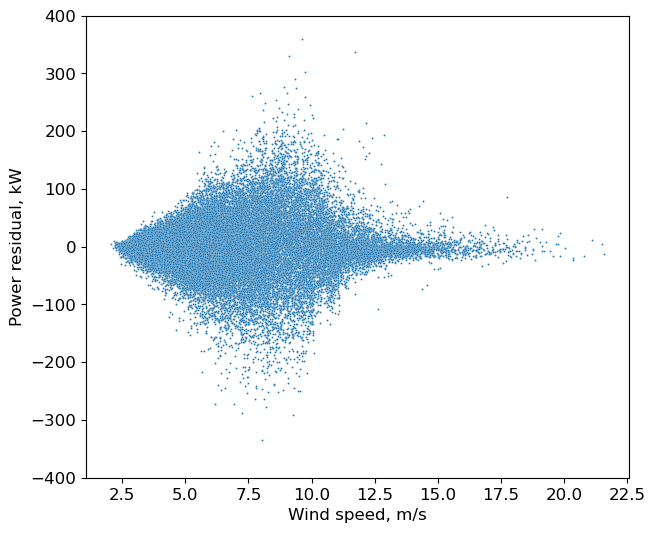

In [40]:
plt.rc('font', size=12)
plt.subplots(figsize=(7, 6))
sns.scatterplot(data = temp_data, x = "Wind_speed", y = "Error", s = 2)
plt.ylabel("Power residual, kW")
plt.xlabel("Wind speed, m/s")
plt.ylim([-400, 400])
plt.show()

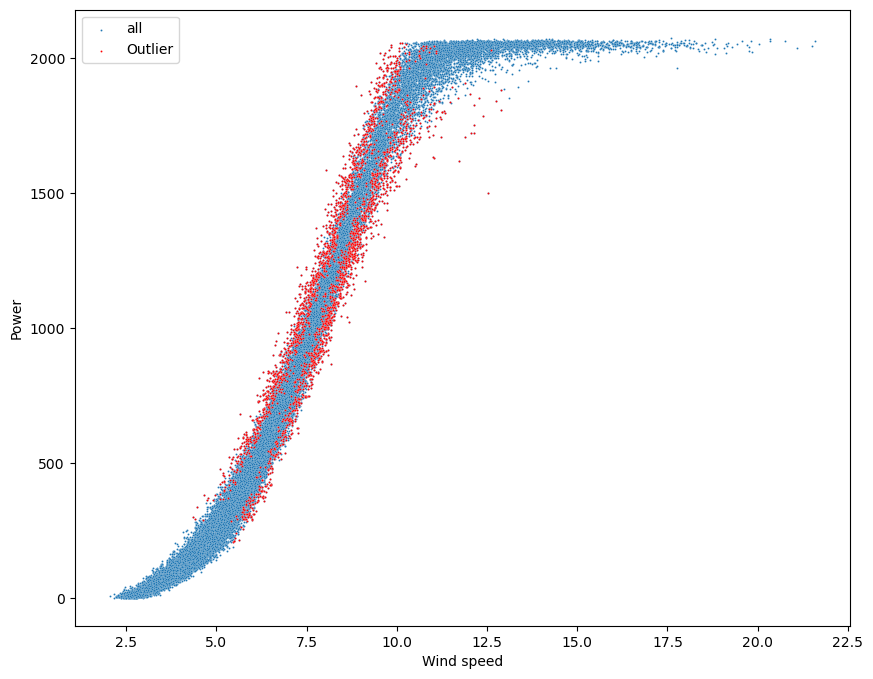

In [35]:
plt.subplots(figsize = (10,8))
sns.scatterplot( data = temp_data, x = 'Wind_speed', y = 'Power', s = 2, label = 'all')
sns.scatterplot( data = temp_outlier, x = 'Wind_speed', y = 'Power', s = 2, label = 'Outlier', color = "Red")
plt.xlabel('Wind speed')
plt.ylabel('Power')
plt.legend()
plt.show()

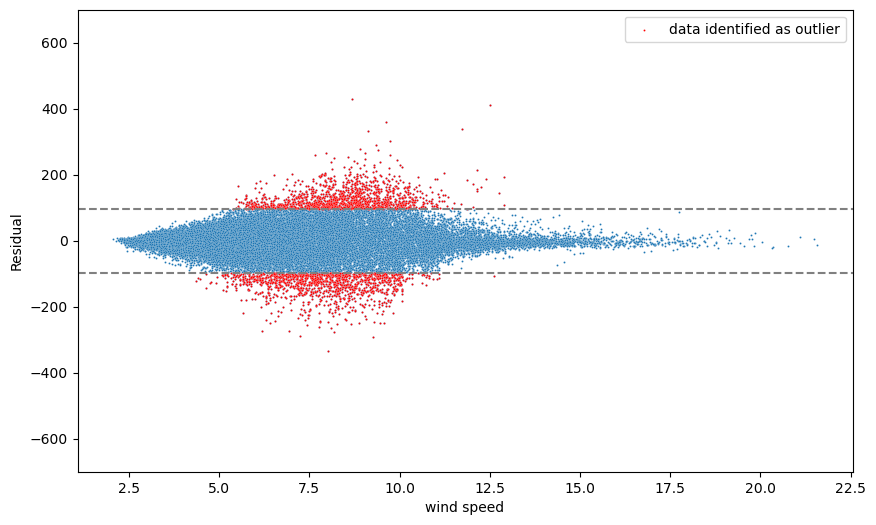

In [36]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Wind_speed", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "Wind_speed", y = "Error", s = 2, color = "red", label = "data identified as outlier")
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.ylabel("Residual")
plt.xlabel("wind speed")
plt.ylim([-700, 700])
plt.savefig('C:/Users/User/Desktop/figures/hetero-controlchart.pdf')
plt.show()

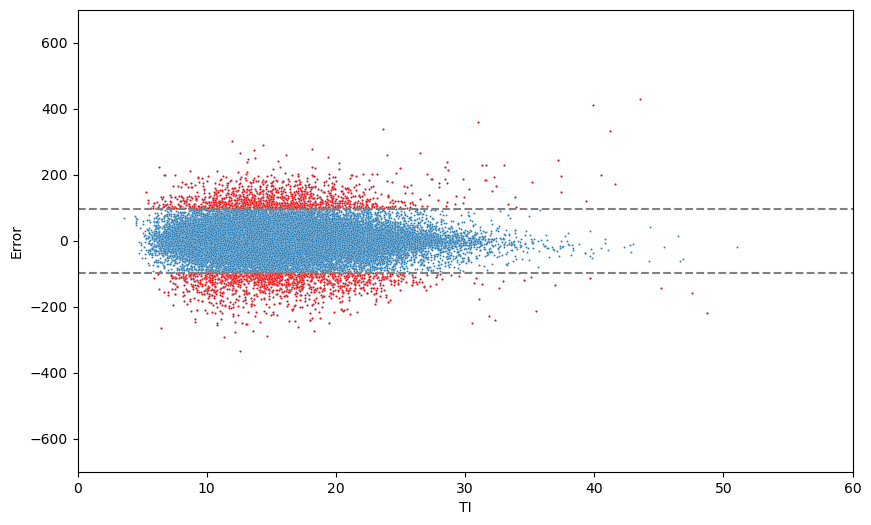

In [37]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "TI", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "TI", y = "Error", s = 2, color = "red")
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.ylim([-700, 700])
plt.xlim([0, 60])
plt.show()

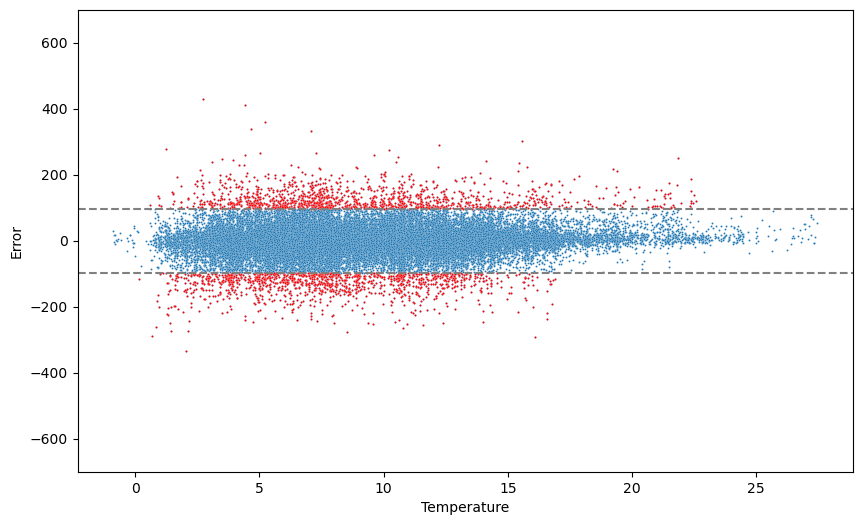

In [38]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Temperature", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "Temperature", y = "Error", s = 2, color = "red")
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.ylim([-700, 700])
plt.show()